In [9]:
#Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from datetime import datetime, timedelta
from tqdm import tqdm
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

In [10]:
# Load Large Cap stocks CSV data into a DataFrame
file_path = 'stock_data_LC.CSV'
result_df = pd.read_csv(file_path)
result_df = result_df.dropna()
# Display the DataFrame
result_df


S.No.           Name  enterpriseValue     ebidt      ebit  netProfit  \
0       1         ABB.NS        157759.11   1802.75   1962.37    1456.45   
1       2  ADANIENSOL.NS        143888.73   6181.93   4405.85    1195.61   
2       3    ADANIENT.NS        393535.30  12938.27   9896.12    3335.27   
3       4  ADANIPORTS.NS        311146.61  17079.94  13191.48    8103.99   
4       5        ATGL.NS        101000.72   1165.64   1007.76     667.50   
..    ...            ...              ...       ...       ...        ...   
95     96         VBL.NS        188654.26   3795.75   3180.95    2211.22   
96     97        VEDL.NS        223937.27  37748.00  27025.00    7539.00   
97     98       WIPRO.NS        236621.06  19383.30  15976.20   11112.10   
98     99      ZOMATO.NS        152021.51    889.00    363.00     351.00   
99    100   ZYDUSLIFE.NS        100684.74   5668.40   4904.30    3972.80   

    freeCashFlow  cashFlowOperations  cashFlowInvesting     assets  ...  \
0        1168.40             1351.48           -3352.01   11001.19  ...   
1         608.08             6037.62           -4942.96   58538.38  ...   
2      -11934.07            10312.19          -18766.65  160586.24  ...   
3        7627.99            15017.58           -6767.56  116999.20  ...   
4         155.89              955.13            -752.28    6591.86  ...   
..           ...                 ...                ...        ...  ...   
95       -803.14             2390.78           -3287.80   15187.18  ...   
96      19097.00            35654.00          -13686.00  190807.00  ...   
97      16972.80            17621.60            1168.00  114790.60  ...   
98        444.00              646.00            -347.00   23356.00  ...   
99       2345.00             3227.90           -1475.20   29280.80  ...   

    pitroski  freeCashFlow5Yrs  roce5Yrs   ebitdYield  earningsYield  \
0          9           3026.72     18.23  0.011427232    0.012439028   
1          7           2095.15     10.19  0.042963268    0.030619841   
2          6         -18806.36      8.58  0.032877025    0.025146715   
3          8          26415.86     11.77  0.054893544    0.042396348   
4          8           -286.87     26.51  0.011540908    0.009977751   
..       ...               ...       ...          ...            ...   
95         7            703.86     20.31  0.020120139    0.016861268   
96         5          92059.00     20.10  0.168565063    0.120681118   
97         8          58456.30     19.54  0.081917053    0.067518081   
98         7          -4444.88    -32.77  0.005847857     0.00238782   
99         7           9581.90     15.22  0.056298502    0.048709467   

        fcfYield  liquidity  fcfToDebt     accrualCF  fcf5YrsYield  
0    0.007406228   0.003997  23.854635   0.314236914   0.019185707  
1    0.004226043   0.000406   0.016404    0.00172451   0.014560904  
2   -0.030325285   0.000971  -0.182729   0.073416813  -0.047788242  
3    0.024515742   0.001323   0.155146  -0.001248128   0.084898434  
4    0.001543454   0.000270   0.100106   0.070488451  -0.002840277  
..           ...        ...        ...           ...           ...  
95  -0.004257206   0.001010  -0.147872    0.20466209   0.003730952  
96   0.085278346   0.000548   0.262426  -0.075620915   0.411092803  
97   0.071729879   0.001581   1.030847  -0.066882654   0.247046058  
98   0.002920639   0.000005   0.592790   0.002226409  -0.029238494  
99    0.02329052   0.002915   2.915941   0.075821016   0.095167351  

[100 rows x 25 columns]

In [11]:
# Function to calculate twelve-month momentum
def calculate_twelve_month_momentum(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period='1y')['Close']
    twelve_month_momentum = (hist.iloc[-1] / hist.iloc[0] - 1) * 100
    return twelve_month_momentum

# Calculate twelve-month momentum for each ticker
twelve_month_momentum = [calculate_twelve_month_momentum(ticker) for ticker in result_df['Name']]

# Insert the calculated momentum values into result_df
result_df['Twelve-Month Momentum'] = twelve_month_momentum
result_df

S.No.           Name  enterpriseValue     ebidt      ebit  netProfit  \
0       1         ABB.NS        157759.11   1802.75   1962.37    1456.45   
1       2  ADANIENSOL.NS        143888.73   6181.93   4405.85    1195.61   
2       3    ADANIENT.NS        393535.30  12938.27   9896.12    3335.27   
3       4  ADANIPORTS.NS        311146.61  17079.94  13191.48    8103.99   
4       5        ATGL.NS        101000.72   1165.64   1007.76     667.50   
..    ...            ...              ...       ...       ...        ...   
95     96         VBL.NS        188654.26   3795.75   3180.95    2211.22   
96     97        VEDL.NS        223937.27  37748.00  27025.00    7539.00   
97     98       WIPRO.NS        236621.06  19383.30  15976.20   11112.10   
98     99      ZOMATO.NS        152021.51    889.00    363.00     351.00   
99    100   ZYDUSLIFE.NS        100684.74   5668.40   4904.30    3972.80   

    freeCashFlow  cashFlowOperations  cashFlowInvesting     assets  ...  \
0        1168.40             1351.48           -3352.01   11001.19  ...   
1         608.08             6037.62           -4942.96   58538.38  ...   
2      -11934.07            10312.19          -18766.65  160586.24  ...   
3        7627.99            15017.58           -6767.56  116999.20  ...   
4         155.89              955.13            -752.28    6591.86  ...   
..           ...                 ...                ...        ...  ...   
95       -803.14             2390.78           -3287.80   15187.18  ...   
96      19097.00            35654.00          -13686.00  190807.00  ...   
97      16972.80            17621.60            1168.00  114790.60  ...   
98        444.00              646.00            -347.00   23356.00  ...   
99       2345.00             3227.90           -1475.20   29280.80  ...   

    freeCashFlow5Yrs  roce5Yrs   ebitdYield  earningsYield      fcfYield  \
0            3026.72     18.23  0.011427232    0.012439028   0.007406228   
1            2095.15     10.19  0.042963268    0.030619841   0.004226043   
2          -18806.36      8.58  0.032877025    0.025146715  -0.030325285   
3           26415.86     11.77  0.054893544    0.042396348   0.024515742   
4            -286.87     26.51  0.011540908    0.009977751   0.001543454   
..               ...       ...          ...            ...           ...   
95            703.86     20.31  0.020120139    0.016861268  -0.004257206   
96          92059.00     20.10  0.168565063    0.120681118   0.085278346   
97          58456.30     19.54  0.081917053    0.067518081   0.071729879   
98          -4444.88    -32.77  0.005847857     0.00238782   0.002920639   
99           9581.90     15.22  0.056298502    0.048709467    0.02329052   

    liquidity  fcfToDebt     accrualCF  fcf5YrsYield Twelve-Month Momentum  
0    0.003997  23.854635   0.314236914   0.019185707            108.368883  
1    0.000406   0.016404    0.00172451   0.014560904             24.654690  
2    0.000971  -0.182729   0.073416813  -0.047788242             32.865141  
3    0.001323   0.155146  -0.001248128   0.084898434             95.644531  
4    0.000270   0.100106   0.070488451  -0.002840277             44.741386  
..        ...        ...           ...           ...                   ...  
95   0.001010  -0.147872    0.20466209   0.003730952            103.474607  
96   0.000548   0.262426  -0.075620915   0.411092803             70.238928  
97   0.001581   1.030847  -0.066882654   0.247046058             20.700801  
98   0.000005   0.592790   0.002226409  -0.029238494            151.336045  
99   0.002915   2.915941   0.075821016   0.095167351            110.368284  

[100 rows x 26 columns]

In [12]:
# Define whether higher or lower values are better for each ratio
higher_is_better = {
    'fcf5YrsYield': True,
    'priceToBook': False,
    'Twelve-Month Momentum': True,
}

# Calculate percentiles for each ratio
for ratio, is_higher_better in higher_is_better.items():
    result_df[f'{ratio} Percentile'] = result_df[ratio].rank(pct=True, ascending=is_higher_better) * 100

In [13]:
# Calculate Composite Score
percentile_columns = [f'{ratio} Percentile' for ratio in higher_is_better.keys()]
result_df['Composite Score'] = result_df[percentile_columns].mean(axis=1)

# Rank companies based on Composite Score
result_df['Rank'] = result_df['Composite Score'].rank(ascending=False).astype(int)

# Display results in ascending order of rank
result_df_sorted = result_df.sort_values(by='Rank')
result_df_sorted.reset_index(drop=True, inplace=True)
result_df_sorted

S.No.           Name  enterpriseValue      ebidt      ebit  netProfit  \
0      12  BAJAJ-AUTO.NS        174134.96   47382.29  40611.03   26858.84   
1      66        ONGC.NS        413815.21  117453.41  88690.67   57100.84   
2      86   TATAPOWER.NS        276830.06   24056.77  14174.61   -4909.61   
3      54  JINDALSTEL.NS        110506.30   10357.25   7535.50    5943.32   
4      26   COALINDIA.NS        248809.21   56367.40  49631.98   37369.13   
..    ...            ...              ...        ...       ...        ...   
95     89       TITAN.NS        301547.09    5826.00   5242.00    3496.00   
96      5        ATGL.NS        101000.72    1165.64   1007.76     667.50   
97     64   NESTLEIND.NS        233635.89    4592.20   4402.52    3196.20   
98     67       PIIND.NS         51999.22     910.04   1063.36     745.20   
99     10       DMART.NS        296258.01    4250.22   3519.46    2535.61   

    freeCashFlow  cashFlowOperations  cashFlowInvesting     assets  ...  \
0       26606.03            35935.90          -10520.58  202417.75  ...   
1       61597.94            99262.68          -57266.81  710192.97  ...   
2        2569.47            20300.67          -14251.44  273423.50  ...   
3       -2418.26             6008.35           -8344.07   78715.18  ...   
4        1794.57            18103.10           -4485.80  237672.26  ...   
..           ...                 ...                ...        ...  ...   
95       1024.00             1695.00            -189.00   31550.00  ...   
96        155.89              955.13            -752.28    6591.86  ...   
97       2027.63             3392.19            -926.99   10523.06  ...   
98        781.35              825.77              -9.91    2226.52  ...   
99         24.04             2745.84           -2468.23   21177.20  ...   

    liquidity   fcfToDebt     accrualCF  fcf5YrsYield  Twelve-Month Momentum  \
0    0.003550    0.487298    0.00713139   0.304838041             118.805601   
1    0.003684    0.402126   0.021268825   0.479431169              82.835948   
2   -0.000112    0.029506  -0.040080096   0.335278618             100.156148   
3    0.002367   -0.146809   0.105177172   0.272045847              95.287197   
4    0.002826    0.275113   0.099935222   0.203018047             128.947958   
..        ...         ...           ...           ...                    ...   
95   0.003455    0.065945   0.063074485   0.014395762              21.824085   
96   0.000270    0.100106   0.070488451  -0.002840277              44.741386   
97   0.007084    5.885206   0.069466486   0.042172159              12.830265   
98   0.092011  218.254190  -0.031735623   0.057115857              -4.476008   
99   0.006072    0.040597   0.106624105  -0.005561402              27.939055   

    fcf5YrsYield Percentile  priceToBook Percentile  \
0                      93.0                    90.0   
1                      99.0                    99.0   
2                      94.0                    84.0   
3                      91.0                    83.0   
4                      85.0                    72.0   
..                      ...                     ...   
95                     24.0                     7.0   
96                      2.0                     8.0   
97                     40.0                     2.0   
98                     46.0                     3.0   
99                      4.0                    15.0   

    Twelve-Month Momentum Percentile Composite Score Rank  
0                               94.0       92.333333    1  
1                               75.0       91.000000    2  
2                               82.0       86.666667    3  
3                               78.0       84.000000    4  
4                               95.0       84.000000    4  
..                               ...             ...  ...  
95                              33.0       21.333333   95  
96                              53.0       21.000000   97  
97              

In [14]:
# Select top 20% based on rank
top_20_percent = result_df_sorted.head(int(len(result_df_sorted) * 0.2))
top_20 = top_20_percent['Name']
top_20

0     BAJAJ-AUTO.NS
1           ONGC.NS
2      TATAPOWER.NS
3     JINDALSTEL.NS
4      COALINDIA.NS
5           NTPC.NS
6      MOTHERSON.NS
7            PNB.NS
8           VEDL.NS
9      ZYDUSLIFE.NS
10    BANKBARODA.NS
11    HEROMOTOCO.NS
12         CANBK.NS
13          LICI.NS
14           HAL.NS
15           IOC.NS
16          PGHH.NS
17    ADANIPORTS.NS
18         CIPLA.NS
19     ICICIBANK.NS
Name: Name, dtype: object

In [15]:
#Backtesting
def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

def preprocess_data(data):
    data["Return_6months"] = (data["Adj Close"] / data["Adj Close"].shift(126) - 1) * 100
    data["Return_3months"] = (data["Adj Close"] / data["Adj Close"].shift(63) - 1) * 100
    data["Return_1month"] = (data["Adj Close"] / data["Adj Close"].shift(21) - 1) * 100
    data["Return_1week"] = (data["Adj Close"] / data["Adj Close"].shift(5) - 1) * 100
    data["Return_1day"] = (data["Adj Close"] / data["Adj Close"].shift(1) - 1) * 100

    

    return data

nifty50_data = {}
start_date = "2023-01-01"
end_date = "2024-06-15"

# Fetch Nifty50 data
for symbol in top_20:
    nifty50_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

# trade data storage
trade_data = []

# Iterate over the stocks
for symbol, stock_data in nifty50_data.items():
    processed_data = preprocess_data(stock_data)

    # Check if there are enough data points
    if len(processed_data) < 2:
        print(f"Not enough data for {symbol}. Skipping...")
        continue

    # Buy shares on the start date
    initial_capital = 1000000
    shares_bought = int(initial_capital / processed_data["Close"].iloc[0])
    trade_data.append({"Symbol": symbol, "Action": "Buy", "Buy Date": processed_data.index[0], "Price": processed_data["Close"].iloc[0], "Shares": shares_bought, "Capital": initial_capital, "Profit/Loss": 0, "Sell Date": None, "Days in Trade": 0})

    # Sell shares on the end date
    capital = shares_bought * processed_data["Close"].iloc[-1]
    profit_loss = capital - initial_capital
    trade_data[-1]["Sell Date"] = processed_data.index[-1]
    trade_data[-1]["Days in Trade"] = len(pd.bdate_range(trade_data[-1]["Buy Date"], trade_data[-1]["Sell Date"]))
    trade_data.append({"Symbol": symbol, "Action": "Sell", "Buy Date": None, "Sell Date": processed_data.index[-1], "Days in Trade": 0, "Price": processed_data["Close"].iloc[-1], "Shares": shares_bought, "Capital": capital, "Profit/Loss": profit_loss})


trade_df = pd.DataFrame(trade_data)
trade_df.to_csv("QVM_.csv", index=False)

# Calculate total initial capital and total final capital
total_initial_capital = trade_df[trade_df["Action"] == "Buy"]["Capital"].sum()
total_final_capital = total_initial_capital + trade_df[trade_df["Action"] == "Sell"]["Profit/Loss"].sum()

# Display the final capital, percentage return, and in-trade days for each stock
for symbol in nifty50_data.keys():
    final_capital = trade_df[(trade_df["Symbol"] == symbol) & (trade_df["Action"] == "Sell")]["Capital"].iloc[0]
    percentage_return = (final_capital - initial_capital) / initial_capital * 100
    in_trade_days = trade_df[(trade_df["Symbol"] == symbol) & (trade_df["Action"] == "Sell")]["Days in Trade"].iloc[0]
    print(f"Symbol: {symbol}, Final Capital: {final_capital:.2f}, Percentage Return: {percentage_return:.2f}%, In-Trade Days: {in_trade_days}")

# Define the symbol for Nifty50
nifty50_symbol = "^NSEI"

# Download Nifty50 historical data
nifty50_data = yf.download(nifty50_symbol, start=start_date, end=end_date)

# Calculate total return
start_value = nifty50_data["Adj Close"].iloc[0]
end_value = nifty50_data["Adj Close"].iloc[-1]
total_return = ((end_value / start_value) - 1) * 100

# Display the total percentage return across all stocks
total_percentage_return = (total_final_capital - total_initial_capital) / total_initial_capital * 100
print(f"Total Initial Capital: {total_initial_capital:.2f}")
print(f"Total Final Capital Across All Stocks: {total_final_capital:.2f}")
print(f"Total Percentage Return Across All Stocks: {total_percentage_return:.2f}%")
# Display the total return of Nifty50
print(f"Total Return of Nifty50: {total_return:.2f}%")

# trade data storage
y_trade_data = []
nifty_stocks = ["^NSEI"]    
# Iterate over the years
years = range(int(start_date[:4]), int(end_date[:4]))
for year in years:
    # Fetch stock data for each stock
    stock_data_dict = {}
    for symbol in top_20:
        stock_data_dict[symbol] = fetch_stock_data(symbol, f"{year}-01-01", f"{year}-12-31")

    #yearly returns
    yearly_returns = {}

    # Iterate over the stocks
    y_total_portfolio_value = 0
    y_total_initial_capital = 0
    for symbol, stock_data in stock_data_dict.items():
        # Check if there are enough data points
        if len(stock_data) < 2:
            print(f"Not enough data for {symbol} in {year}. Skipping...")
            continue

        # Buy shares on the start date
        y_initial_capital = 100000
        y_shares_bought = int(y_initial_capital / stock_data["Close"].iloc[0])
        y_capital = y_shares_bought * stock_data["Close"].iloc[-1]
        y_total_portfolio_value += y_capital
        y_total_initial_capital += y_initial_capital
   
    # Fetch stock data for each stock
    n_stock_data_dict = {}

    for symbol in nifty_stocks:
        n_stock_data_dict[symbol] = fetch_stock_data(symbol, f"{year}-01-01", f"{year}-12-31")

    # nifty yearly returns
    n_yearly_returns = {}

    # Iterate over the stocks
    n_total_portfolio_value = 0
    n_total_initial_capital = 0
    for symbol, stock_data in n_stock_data_dict.items():
        # Check if there are enough data points
        if len(stock_data) < 2:
            print(f"Not enough data for {symbol} in {year}. Skipping...")
            continue

        # Buy shares on the start date
        n_initial_capital = 100000
        n_shares_bought = int(n_initial_capital / stock_data["Close"].iloc[0])
        n_capital = n_shares_bought * stock_data["Close"].iloc[-1]
        n_total_portfolio_value += n_capital
        n_total_initial_capital += n_initial_capital

    # Append year and yearly return for the portfolio
    yearly_returns["Year"] = year
    yearly_returns["Nifty_50"] = ((n_total_portfolio_value - n_total_initial_capital) / n_total_initial_capital) * 100
    yearly_returns["Portfolio"] = ((y_total_portfolio_value - y_total_initial_capital) / y_total_initial_capital) * 100

    # Append yearly returns to trade data
    y_trade_data.append(yearly_returns)


y_trade_df = pd.DataFrame(y_trade_data)


# Calculate CAGR (Compound Annual Growth Rate)
start_year = int(start_date[:4])
end_year = int(end_date[:4])
years = end_year - start_year

# CAGR formula: ((final value / beginning value) ^ (1 / no of years)) - 1
cagr = ((total_final_capital / total_initial_capital) ** (1 / years)) - 1
print(f"CAGR (Compound Annual Growth Rate of Portfolio): {cagr:.2%}")

# Calculate and print Nifty CAGR
nifty_cagr = ((end_value / start_value) ** (1 / years)) - 1
print(f"CAGR (Compound Annual Growth Rate of Nifty): {nifty_cagr:.2%}")

#Portfolio optimization
#Define the stock tickers and historical data
stock_tickers = top_20
start_year = int(start_date[:4])
end_year = int(end_date[:4])

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

#Function to calculate portfolio returns for a given year
def calculate_portfolio_metrics(weights, year):
    #Fetch historical data for each stock
    stock_data = pd.DataFrame({ticker: fetch_historical_data(ticker, f"{year}-01-01", f"{year+1}-01-01") for ticker in stock_tickers})

    #Calculate portfolio returns
    portfolio_returns = (stock_data.pct_change() * weights).sum(axis=1).dropna()

    #Calculate portfolio cumulative returns
    cumulative_returns = (portfolio_returns + 1).cumprod()

    #Calculate total return for the year
    total_return = cumulative_returns.iloc[-1] - 1

    return total_return, weights  #Return the total return and weights for the year

#Initialize empty dictionary to store annual returns and weights
annual_returns_and_weights = {}

#Loop through each year
for year in range(start_year, end_year):
    #Fetch historical stock data
    stock_data = pd.DataFrame({ticker: fetch_historical_data(ticker, f"{year}-01-01", f"{year+1}-01-01") for ticker in stock_tickers})

    #Calculate expected returns and sample covariance matrix of asset returns
    mu = expected_returns.mean_historical_return(stock_data)
    cov_matrix = risk_models.sample_cov(stock_data)

    #Optimize for maximum Sharpe ratio
    ef = EfficientFrontier(mu, cov_matrix)
    weights = ef.max_sharpe(risk_free_rate= 0.06)  #Assuming a risk-free rate of -3%

    #Calculate portfolio metrics for the year using the optimal weights
    annual_returns_and_weights[year] = calculate_portfolio_metrics(weights, year)

#Print annual returns and weights
for year, (return_value, weights) in annual_returns_and_weights.items():
    print(f"Year: {year}")
    print(f"Return: {return_value:.2%}")
    print("Weights:")
    for ticker, weight in weights.items():
        print(f"{ticker}: {weight:.2%}")
    print()

#Display trade data
print(trade_df)
print(y_trade_df)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

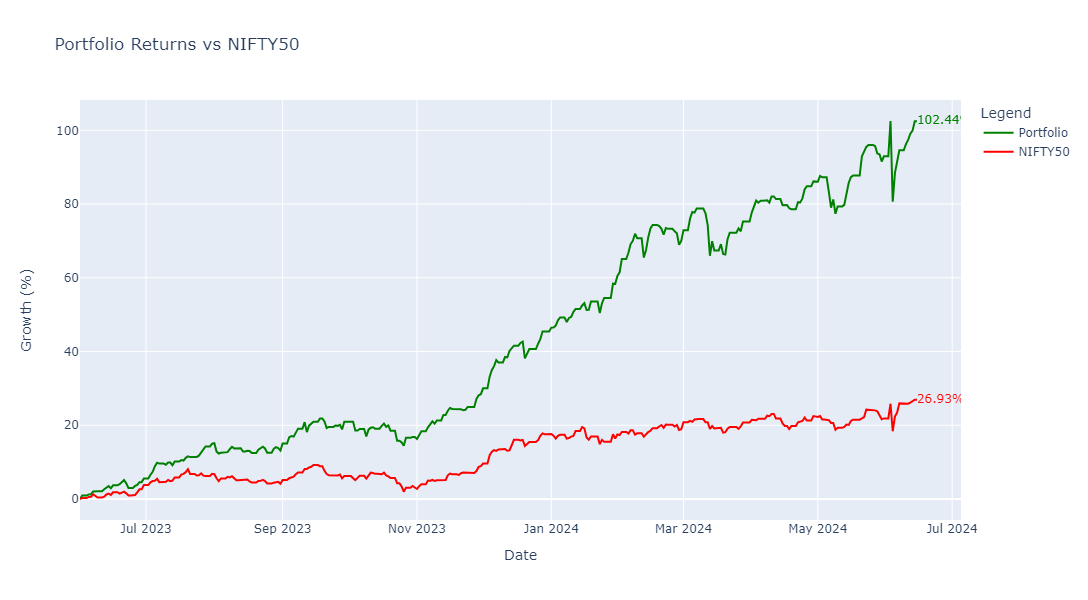

In [16]:
#Simulation of the portfolio returns vs NIFTY50

# Fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data['Adj Close']

# Initialize parameters
start_date = "2023-06-01"
end_date = "2024-06-15"
initial_capital = 500000

# Fetch historical stock data for the portfolio
portfolio_data = pd.DataFrame({ticker: fetch_stock_data(ticker, start_date, end_date) for ticker in top_20})

# Align all data to the same date range
portfolio_data = portfolio_data.reindex(pd.date_range(start=start_date, end=end_date)).ffill().bfill()

# Initialize portfolio value dataframe
portfolio_value_over_time = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date))
portfolio_value_over_time['Portfolio Value'] = 0

# Calculate the number of shares bought for each stock on the start date
shares_bought = {}
for ticker in top_20:
    shares_bought[ticker] = initial_capital / len(top_20) / portfolio_data[ticker].iloc[0]

# Calculate the daily portfolio value
for date in portfolio_value_over_time.index:
    daily_portfolio_value = 0
    for ticker in top_20:
        if date in portfolio_data.index:
            daily_portfolio_value += shares_bought[ticker] * portfolio_data[ticker].loc[date]
    portfolio_value_over_time.loc[date, 'Portfolio Value'] = daily_portfolio_value

# Handle NaN values
portfolio_value_over_time.dropna(inplace=True)

# Resample to ensure alignment
portfolio_value_over_time = portfolio_value_over_time.resample('D').ffill()
nifty_data = fetch_stock_data('^NSEI', start_date, end_date).resample('D').ffill()

# Calculate cumulative growth
nifty_growth = (nifty_data / nifty_data.iloc[0] - 1) * 100
portfolio_growth = (portfolio_value_over_time['Portfolio Value'] / portfolio_value_over_time['Portfolio Value'].iloc[0] - 1) * 100

# Ensure both growth data are aligned by reindexing
aligned_index = portfolio_growth.index.union(nifty_growth.index)
portfolio_growth = portfolio_growth.reindex(aligned_index).ffill()
nifty_growth = nifty_growth.reindex(aligned_index).ffill()

# Plotting the growth of the portfolio and NIFTY50 with Plotly
fig = make_subplots()

fig.add_trace(go.Scatter(x=portfolio_growth.index, y=portfolio_growth, mode='lines', name='Portfolio', line=dict(color='green')))
fig.add_trace(go.Scatter(x=nifty_growth.index, y=nifty_growth, mode='lines', name='NIFTY50', line=dict(color='red')))

# Annotate the final value of each line
final_nifty_return = nifty_growth.iloc[-1]
final_portfolio_return = portfolio_growth.iloc[-1]
fig.add_trace(go.Scatter(x=[nifty_growth.index[-1]], y=[final_nifty_return], mode='text', text=[f'{final_nifty_return:.2f}%'], textposition='middle right', showlegend=False, textfont=dict(color='red')))
fig.add_trace(go.Scatter(x=[portfolio_growth.index[-1]], y=[final_portfolio_return], mode='text', text=[f'{final_portfolio_return:.2f}%'], textposition='middle right', showlegend=False, textfont=dict(color='green')))

fig.update_layout(
    title='Portfolio Returns vs NIFTY50',
    xaxis_title='Date',
    yaxis_title='Growth (%)',
    legend_title='Legend',
    hovermode='x unified',
    height=600
)

fig.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

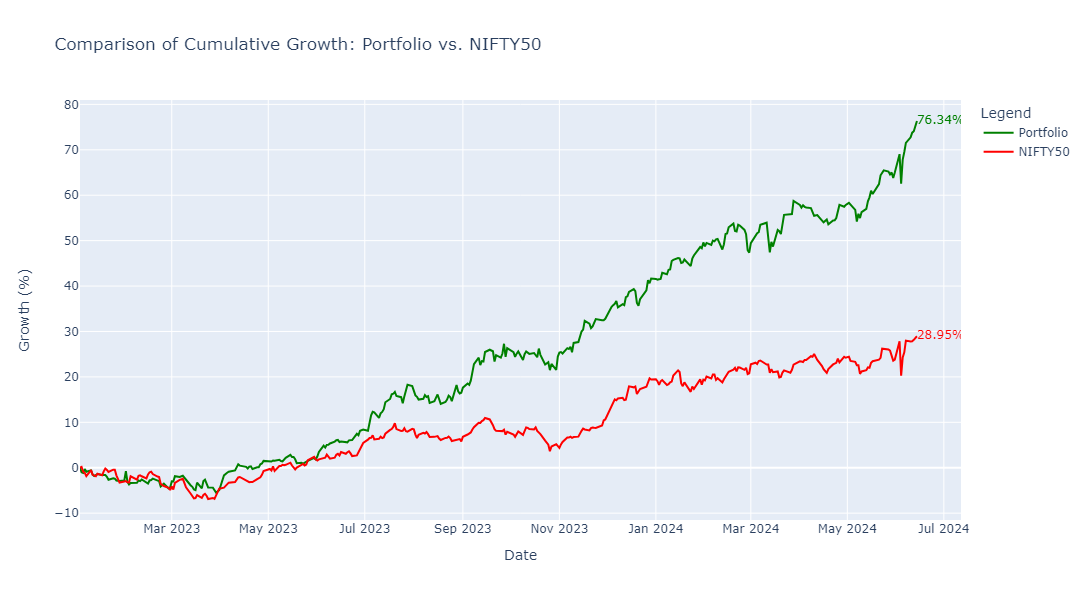

In [42]:
#Visualization of cummilative growth of NIFTY50 & Portfolio

# Define the top 20 stock tickers
stock_tickers = top_20

# Define the date range
start_date = '2023-01-01'
end_date = '2024-06-15'

# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Handle missing data by forward-filling
portfolio_data = portfolio_data.ffill().bfill()

# Calculate cumulative growth for Nifty50
nifty_growth = (nifty_data / nifty_data.iloc[0] - 1) * 100

# Calculate cumulative growth for the portfolio (equal-weighted)
portfolio_growth = (portfolio_data.sum(axis=1) / portfolio_data.sum(axis=1).iloc[0] - 1) * 100

# Ensure both growth data are aligned by reindexing
aligned_index = portfolio_growth.index.union(nifty_growth.index)
portfolio_growth = portfolio_growth.reindex(aligned_index).ffill()
nifty_growth = nifty_growth.reindex(aligned_index).ffill()

# Verify calculation logic
nifty_growth_correct = (nifty_data / nifty_data.iloc[0] - 1) * 100
portfolio_growth_correct = (portfolio_data.sum(axis=1) / portfolio_data.sum(axis=1).iloc[0] - 1) * 100


# Plotting the cumulative growth of the portfolio and NIFTY50 with Plotly
fig = make_subplots()

fig.add_trace(go.Scatter(x=portfolio_growth.index, y=portfolio_growth, mode='lines', name='Portfolio', line=dict(color='green')))
fig.add_trace(go.Scatter(x=nifty_growth.index, y=nifty_growth, mode='lines', name='NIFTY50', line=dict(color='red')))

# Annotate the final value of each line
final_nifty_return = nifty_growth.iloc[-1]
final_portfolio_return = portfolio_growth.iloc[-1]
fig.add_trace(go.Scatter(x=[nifty_growth.index[-1]], y=[final_nifty_return], mode='text', text=[f'{final_nifty_return:.2f}%'], textposition='middle right', showlegend=False, textfont=dict(color='red')))
fig.add_trace(go.Scatter(x=[portfolio_growth.index[-1]], y=[final_portfolio_return], mode='text', text=[f'{final_portfolio_return:.2f}%'], textposition='middle right', showlegend=False, textfont=dict(color='green')))

fig.update_layout(
    title='Comparison of Cumulative Growth: Portfolio vs. NIFTY50',
    xaxis_title='Date',
    yaxis_title='Growth (%)',
    legend_title='Legend',
    hovermode='x unified',
    height=600
)

fig.show()


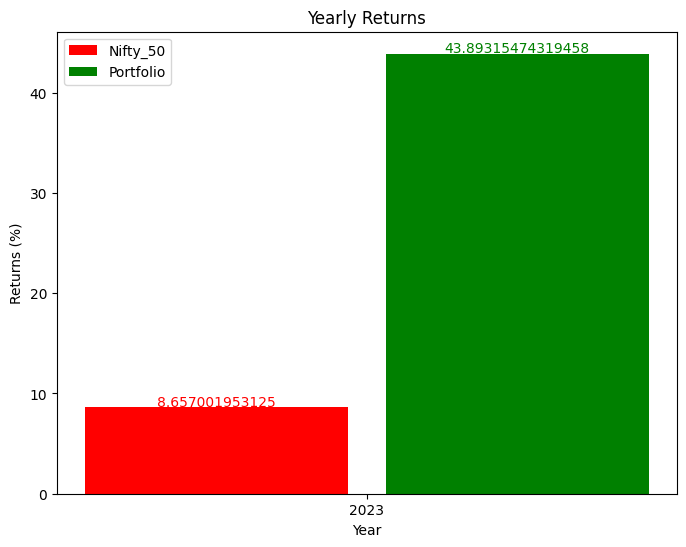

In [18]:
#Visual comparision of yearly returns between portfolio & NIFTY50

# Plotting
plt.figure(figsize=(8, 6))

# Plot Nifty_50 returns
plt.bar(y_trade_df['Year'] - 0.2, y_trade_df['Nifty_50'], width=0.35, label='Nifty_50', color='red')

# Plot Portfolio returns
plt.bar(y_trade_df['Year'] + 0.2, y_trade_df['Portfolio'], width=0.35, label='Portfolio', color='green')

plt.title('Yearly Returns')
plt.xlabel('Year')
plt.ylabel('Returns (%)')
plt.xticks(y_trade_df['Year'])
plt.legend()

# Annotate each bar with its corresponding value
for index, row in y_trade_df.iterrows():
    plt.text(row['Year'] - 0.2, row['Nifty_50'] + 0.1, str(row['Nifty_50']), color='red', ha='center')
    plt.text(row['Year'] + 0.2, row['Portfolio'] + 0.1, str(row['Portfolio']), color='green', ha='center')

plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

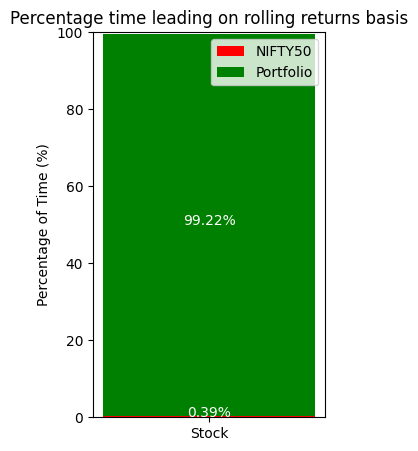

In [19]:
#Visual representation of Percentage Time Leading on 1-year Rolling Basis

# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data up to the end month
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Calculate daily returns for NIFTY50
nifty_daily_returns = nifty_data.pct_change()

# Calculate daily returns for the portfolio (equal-weighted)
portfolio_daily_returns = portfolio_data.mean(axis=1).pct_change()

# Calculate cumulative returns
nifty_cumulative_returns = (1 + nifty_daily_returns).cumprod() - 1
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod() - 1

# Compare cumulative returns and count occurrences
nifty_outperforms = (nifty_cumulative_returns > portfolio_cumulative_returns).sum()
portfolio_outperforms = (nifty_cumulative_returns < portfolio_cumulative_returns).sum()
total_days = len(nifty_cumulative_returns)

# Calculate the percentage of time each outperforms the other
nifty_outperforms_percentage = nifty_outperforms / total_days * 100
portfolio_outperforms_percentage = portfolio_outperforms / total_days * 100

# Plotting
plt.figure(figsize=(3, 5))

# Plot a single stacked bar chart with reduced width
plt.bar(['Stock'], nifty_outperforms_percentage, width=0.2, color='red', label='NIFTY50')
plt.bar(['Stock'], portfolio_outperforms_percentage, bottom=nifty_outperforms_percentage, width=0.2, color='green', label='Portfolio')

plt.title('Percentage time leading on rolling returns basis')
plt.ylabel('Percentage of Time (%)')
plt.legend()

plt.text('Stock', nifty_outperforms_percentage / 2, f'{nifty_outperforms_percentage:.2f}%', color='white', ha='center')
plt.text('Stock', nifty_outperforms_percentage + portfolio_outperforms_percentage / 2, f'{portfolio_outperforms_percentage:.2f}%', color='white', ha='center')

plt.ylim(0, 100)

plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

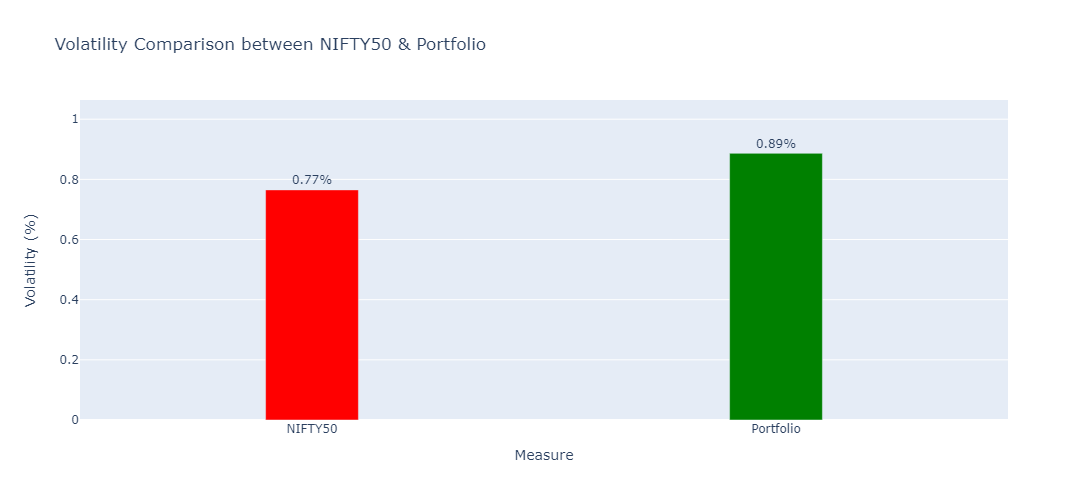

In [43]:
#Visual representation of volatility comparision between portfolio & NIFTY50

# Define the top 20 stock tickers
stock_tickers = top_20

# Define the date range
start_date = '2023-01-01'
end_date = '2024-06-15'

# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Handle missing data by forward-filling and backward-filling
portfolio_data = portfolio_data.ffill().bfill()

# Calculate daily returns for NIFTY50
nifty_daily_returns = nifty_data.pct_change()

# Calculate daily returns for the portfolio (equal-weighted)
portfolio_daily_returns = portfolio_data.mean(axis=1).pct_change()

# Calculate volatility (standard deviation) for NIFTY50
nifty_volatility = nifty_daily_returns.std() * 100  # Converting to percentage

# Calculate portfolio volatility (standard deviation)
portfolio_volatility = portfolio_daily_returns.std() * 100  # Converting to percentage

# Plotting
fig = go.Figure()

# Add bars for NIFTY50 and Portfolio volatilities
fig.add_trace(go.Bar(
    x=['NIFTY50'],
    y=[nifty_volatility],
    name='NIFTY50',
    marker_color='red',
    text=f'{nifty_volatility:.2f}%',
    textposition='outside',
    width=0.2  
))

fig.add_trace(go.Bar(
    x=['Portfolio'],
    y=[portfolio_volatility],
    name='Portfolio',
    marker_color='green',
    text=f'{portfolio_volatility:.2f}%',
    textposition='outside',
    width=0.2  
))

# Update layout
fig.update_layout(
    title='Volatility Comparison between NIFTY50 & Portfolio',
    xaxis_title='Measure',
    yaxis_title='Volatility (%)',
    yaxis=dict(range=[0, max(nifty_volatility, portfolio_volatility) * 1.2]),  # Set y-axis limit to accommodate the bars
    barmode='group',
    showlegend=False,
    height=500,  
    width=800  
)

fig.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

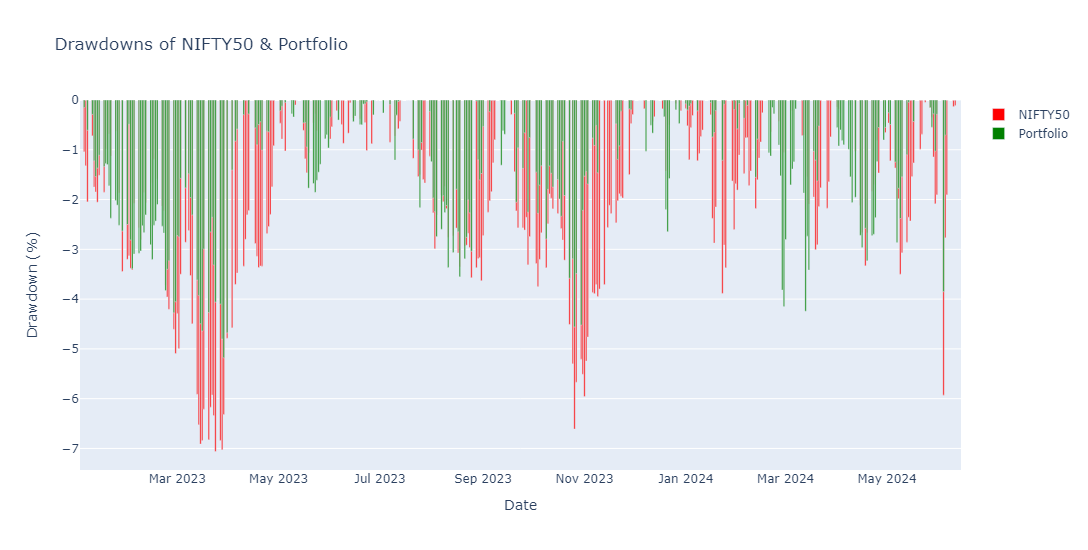

In [44]:
#Drawdowns and maximum drawdown of NIFTY50 & Portfolio

# Define the top 20 stock tickers
stock_tickers = top_20

# Define the date range
start_date = '2023-01-01'
end_date = '2024-06-15'

# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Handle missing data by forward-filling and backward-filling
portfolio_data = portfolio_data.ffill().bfill()

# Calculate daily returns for NIFTY50
nifty_daily_returns = nifty_data.pct_change()

# Calculate the daily returns for the portfolio (equal-weighted)
portfolio_daily_returns = portfolio_data.mean(axis=1).pct_change()

# Calculate the cumulative product of the NIFTY50 returns
nifty_cumulative_returns = (1 + nifty_daily_returns).cumprod()

# Calculate the cumulative product of the portfolio returns
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()

# Calculate the cumulative maximum of the NIFTY50 returns
nifty_cumulative_max = nifty_cumulative_returns.cummax()

# Calculate the cumulative maximum of the portfolio returns
portfolio_cumulative_max = portfolio_cumulative_returns.cummax()

# Calculate the drawdown as the ratio of the returns to the cumulative maximum
nifty_drawdown = (nifty_cumulative_returns - nifty_cumulative_max) / nifty_cumulative_max
portfolio_drawdown = (portfolio_cumulative_returns - portfolio_cumulative_max) / portfolio_cumulative_max

# Print maximum drawdown values
print("Maximum Drawdown:")
print(f"NIFTY50: {nifty_drawdown.min() * 100:.2f}%")
print(f"Portfolio: {portfolio_drawdown.min() * 100:.2f}%")

# Plotting with Plotly
fig = go.Figure()

# Plot the drawdown for NIFTY50 as bars
fig.add_trace(go.Bar(
    x=nifty_drawdown.index, 
    y=nifty_drawdown * 100, 
    name='NIFTY50',
    marker_color='red',
    opacity=1
))

# Plot the drawdown for the portfolio as bars
fig.add_trace(go.Bar(
    x=portfolio_drawdown.index, 
    y=portfolio_drawdown * 100, 
    name='Portfolio',
    marker_color='green',
    opacity=1
))

# Update layout
fig.update_layout(
    title='Drawdowns of NIFTY50 & Portfolio',
    xaxis_title='Date',
    yaxis_title='Drawdown (%)',
    showlegend=True,
    barmode='overlay',  
    height=550,  
    width=800  
)

fig.show()


In [22]:

# Define the stock tickers
stock_tickers = top_20

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Initialize empty dictionary to store historical stock data
stock_data = {}

# Fetch historical stock data for each stock
for ticker in stock_tickers:
    stock_data[ticker] = fetch_historical_data(ticker, start_date, end_date)

# Combine stock data into a single DataFrame
all_stock_data = pd.DataFrame(stock_data)

# Calculate portfolio returns
portfolio_returns = all_stock_data.pct_change().dropna()

# Equal weights for each stock in the portfolio
num_stocks = len(stock_tickers)
equal_weight = 1 / num_stocks

# Calculate average annual returns for each stock
average_annual_returns = portfolio_returns.mean() * 252  # 252 trading days in a year

# Calculate portfolio returns by multiplying the stock weightage to the average stock returns and summing them up
portfolio_annual_return = (average_annual_returns * equal_weight).sum()

# Risk-free rate (assuming 7%)
risk_free_rate = 0.07

# Calculate covariance matrix
covariance_matrix = portfolio_returns.cov() * 252

# Ensure covariance matrix is positive semi-definite
cholesky_factor = np.linalg.cholesky(covariance_matrix + 1e-10 * np.eye(len(covariance_matrix)))

# Calculate portfolio standard deviation
portfolio_std_dev = np.sqrt(np.dot(equal_weight, np.dot(cholesky_factor, cholesky_factor.T).diagonal()))

# Calculate market returns
market_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
market_returns = market_data.pct_change().dropna()

# Align market returns with portfolio returns
market_returns = market_returns[:len(portfolio_returns)]

# Calculate beta of the portfolio
portfolio_beta = np.cov(portfolio_returns.T, market_returns)[0, 1] / np.var(market_returns)

# Calculate Treynor Measure for the portfolio
treynor_measure = (portfolio_annual_return - risk_free_rate) / portfolio_beta

# Calculate Jensen's Alpha for the portfolio
portfolio_alpha = portfolio_annual_return - (risk_free_rate + portfolio_beta * (np.mean(market_returns) * 252 - risk_free_rate))

print ("Portfolio Beta:", portfolio_beta) 
print("Treynor Measure:", treynor_measure)
print("Jensen's Alpha:", portfolio_alpha)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [23]:
#Sharpe ratio
tickers = top_20

# Function to fetch historical stock data
def fetch_historical_data(stock, start, end):
    return yf.download(stock, start=start, end=end)['Adj Close']

# Function to calculate portfolio returns and Sharpe Ratio
def compute_sharpe_ratio(data, weights, risk_free_rate=0.07):
    # Combine stock data into a single DataFrame
    all_stock_data = pd.DataFrame(data)
    
    # Calculate portfolio returns
    stock_returns = all_stock_data.pct_change().dropna()
    
    # Calculate portfolio returns by multiplying the stock weightage to the average stock returns and summing them up
    portfolio_annual_return = (stock_returns.mean() * 252 @ weights)
    
    # Calculate portfolio standard deviation
    portfolio_volatility = np.sqrt(weights.T @ (stock_returns.cov() * 252) @ weights)
    
    # Calculate Sharpe Ratio for the portfolio
    sharpe_ratio = (portfolio_annual_return - risk_free_rate) / portfolio_volatility
    
    return sharpe_ratio[0]  # Return the single Sharpe Ratio value

# Fetch historical stock data for each stock
stock_prices = {}
for ticker in tickers:
    stock_prices[ticker] = fetch_historical_data(ticker, start_date, end_date)

# Equal weights for each stock in the portfolio
num_stocks = len(tickers)
weights_portfolio = np.ones((num_stocks, 1)) / num_stocks

# Calculate Sharpe Ratio of the portfolio with equal weights
sharpe_ratio_portfolio = compute_sharpe_ratio(stock_prices, weights_portfolio)

print("Sharpe Ratio:", sharpe_ratio_portfolio)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [24]:

# Function to fetch historical stock data
def fetch_historical_data(stock, start_date, end_date):
    return yf.download(stock, start=start_date, end=end_date)['Adj Close']

# Function to calculate daily returns
def calculate_daily_returns(data):
    return data.pct_change().dropna()

# Function to calculate tracking error
def calculate_tracking_error(portfolio_data, benchmark_data):
    # Calculate daily returns
    portfolio_returns = calculate_daily_returns(portfolio_data).mean(axis=1)
    benchmark_returns = calculate_daily_returns(benchmark_data)
    
    # Ensure the lengths of portfolio and benchmark returns match
    if len(portfolio_returns) != len(benchmark_returns):
        raise ValueError("Portfolio data and benchmark data must have the same length")

    # Calculate the active returns
    active_returns = portfolio_returns - benchmark_returns

    # Calculate the tracking error (standard deviation of the active returns) and annualize it
    tracking_error = np.std(active_returns) * np.sqrt(252)  # Annualized tracking error
    return tracking_error

# Function to calculate information ratio
def calculate_information_ratio(portfolio_data, benchmark_data, tracking_error):
    # Calculate annualized returns for portfolio and benchmark
    portfolio_daily_returns = calculate_daily_returns(portfolio_data).mean(axis=1)
    benchmark_daily_returns = calculate_daily_returns(benchmark_data)
    
    portfolio_annual_return = np.mean(portfolio_daily_returns) * 252
    benchmark_annual_return = np.mean(benchmark_daily_returns) * 252
    
    # Calculate the information ratio
    information_ratio = (portfolio_annual_return - benchmark_annual_return) / tracking_error
    return information_ratio

# Define the portfolio tickers and benchmark ticker
portfolio_tickers = top_20
benchmark_ticker = '^NSEI'

# Define the start and end dates
start_date = "2023-01-01"
end_date = "2024-06-14"

# Fetch historical stock data for portfolio and benchmark
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in portfolio_tickers})
benchmark_data = fetch_historical_data(benchmark_ticker, start_date, end_date)

# Calculate tracking error
tracking_error = calculate_tracking_error(portfolio_data, benchmark_data)
print("Tracking error:", tracking_error)

# Calculate information ratio
information_ratio = calculate_information_ratio(portfolio_data, benchmark_data, tracking_error)
print("Information Ratio:", information_ratio)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [25]:
# Define the stock tickers and historical data
e_stock_tickers = top_20
e_start_date = "2023-06-01"
e_end_date = "2024-05-31" 

# Function to fetch historical stock data
def e_fetch_historical_data(e_stock_ticker, e_start_date, e_end_date):
    return yf.download(e_stock_ticker, start= e_start_date, end= e_end_date)['Adj Close']

# Fetch historical stock data up to the end date
e_stock_data = pd.DataFrame({ticker: e_fetch_historical_data(ticker, e_start_date, e_end_date) for ticker in e_stock_tickers})

# Calculate daily returns
e_daily_returns = e_stock_data.pct_change().dropna()
print(e_daily_returns.head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

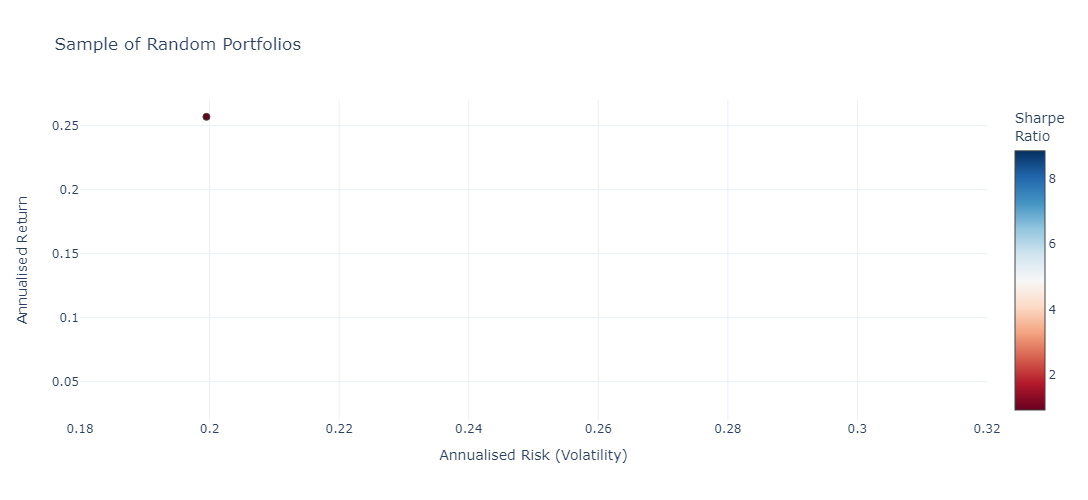

In [26]:
#-- Get annualised mean returns
mus = (1+e_daily_returns.mean())**252 - 1

#-- Get covariances
#- Multiply by 252 to annualise it (square root time for volatility but no square root for variance)
#- Note: 252 trading days in a year
cov = e_daily_returns.cov()*252

#- How many assests to include in each portfolio
n_assets = 4

#-- How many portfolios to generate
n_portfolios = 10000

#-- Initialize empty list to store mean-variance pairs for plotting
mean_variance_pairs = []

np.random.seed(75)

#-- Loop through and generate lots of random portfolios
for i in range(n_portfolios):
    #- Choose assets randomly without replacement
    assets = np.random.choice(list(e_daily_returns.columns), n_assets, replace=False)
    #- Choose weights randomly
    weights = np.random.rand(n_assets)
    #- Ensure weights sum to 1
    weights = weights/sum(weights)

    #-- Loop over asset pairs and compute portfolio return and variance
   
    portfolio_E_Variance = 0
    portfolio_E_Return = 0
    for i in range(len(assets)):
        portfolio_E_Return += weights[i] * mus.loc[assets[i]]
        for j in range(len(assets)):
            #-- Add variance/covariance for each asset pair
            #- Note that when i==j this adds the variance
            portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
            
    #-- Add the mean/variance pairs to a list for plotting
    mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])

#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0.07 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.32])
fig.update_yaxes(range=[0.02,0.27])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

100%|██████████| 10000/10000 [00:03<00:00, 3181.95it/s]

107
    Portfolio Name                                             Stocks  \
0      Portfolio 1           JINDALSTEL.NS, NTPC.NS, CIPLA.NS, PNB.NS   
1      Portfolio 2           ZYDUSLIFE.NS, NTPC.NS, CIPLA.NS, LICI.NS   
2      Portfolio 3  BAJAJ-AUTO.NS, COALINDIA.NS, ZYDUSLIFE.NS, JIN...   
3      Portfolio 4            NTPC.NS, ZYDUSLIFE.NS, HAL.NS, CANBK.NS   
4      Portfolio 5      HEROMOTOCO.NS, HAL.NS, ZYDUSLIFE.NS, CIPLA.NS   
..             ...                                                ...   
102  Portfolio 103  ADANIPORTS.NS, ZYDUSLIFE.NS, HAL.NS, COALINDIA.NS   
103  Portfolio 104  HAL.NS, MOTHERSON.NS, COALINDIA.NS, BAJAJ-AUTO.NS   
104  Portfolio 105            ICICIBANK.NS, CIPLA.NS, HAL.NS, PGHH.NS   
105  Portfolio 106  PGHH.NS, ZYDUSLIFE.NS, ICICIBANK.NS, BAJAJ-AUT...   
106  Portfolio 107        HAL.NS, PNB.NS, ZYDUSLIFE.NS, BAJAJ-AUTO.NS   

                    Weights  
0    0.25, 0.30, 0.21, 0.24  
1    0.37, 0.27, 0.12, 0.24  
2    0.09, 0.27, 0.26, 0.37  

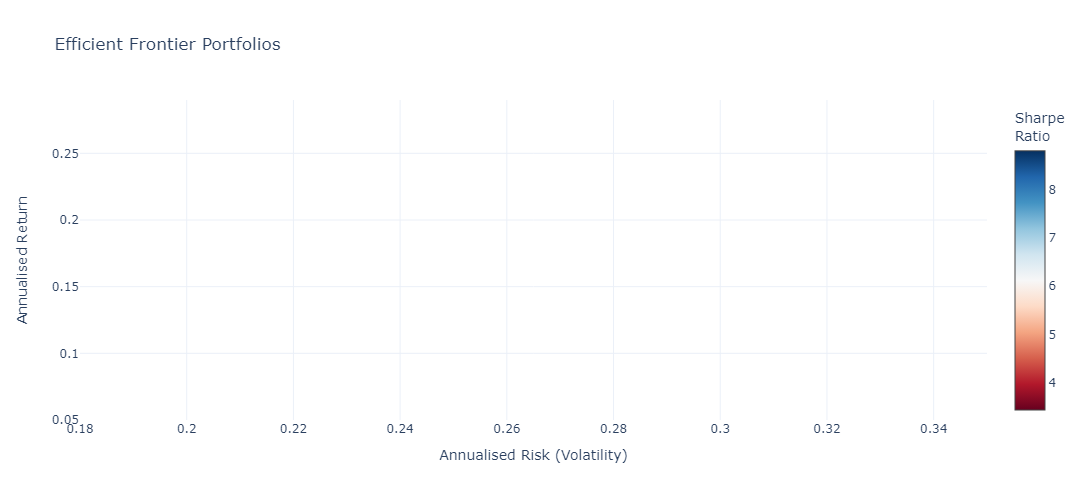

In [27]:
#-- Create random portfolio weights and indexes
#- How many assests in the portfolio
n_assets = 4

mean_variance_pairs = []
weights_list=[]
tickers_list=[]

for i in tqdm(range(10000)):
    next_i = False
    while True:
        #- Choose assets randomly without replacement
        assets = np.random.choice(list(e_daily_returns.columns), n_assets, replace=False)
        #- Choose weights randomly ensuring they sum to one
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        #-- Loop over asset pairs and compute portfolio return and variance
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]

        #-- Skip over dominated portfolios
        for R,V in mean_variance_pairs:
            if (R > portfolio_E_Return) & (V < portfolio_E_Variance):
                next_i = True
                break
        if next_i:
            break

        #-- Add the mean/variance pairs to a list for plotting
        mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

print (len(mean_variance_pairs))


# Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate = 0.07

# Create lists to store portfolio information
stocks_in_portfolios = []
weights_in_portfolios = []
portfolio_names = []  # List to store portfolio names

# Iterate through each portfolio
for i in range(len(tickers_list)):
    # Extract stocks and their weightage for the portfolio
    assets = tickers_list[i]
    weights = weights_list[i]
    
    # Append to the lists
    stocks_in_portfolios.append(", ".join([asset.split(":")[0] for asset in assets]))  # Extracting only the stock names
    weights_in_portfolios.append(", ".join([f"{weight:.2f}" for weight in weights]))  # Extracting only the weights
    portfolio_names.append(f'Portfolio {i+1}')  # Assigning portfolio names

# Create DataFrame from the collected portfolio data
portfolio_df = pd.DataFrame({'Portfolio Name': portfolio_names,
                             'Stocks': stocks_in_portfolios,
                             'Weights': weights_in_portfolios})

# Print portfolio information
print(portfolio_df)

# Create the figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[f"{portfolio_names[i]}<br>{str(np.array(tickers_list[i]))}<br>{str(np.array(weights_list[i]).round(2))}" for i in range(len(tickers_list))]))  # Add portfolio names to text
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Efficient Frontier Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.35])
fig.update_yaxes(range=[0.05,0.29])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

# Show the figure
fig.show()


In [ ]:
# Define start and end dates for future returns calculation
start_date = "2023-01-01"
end_date = "2024-06-15"

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Function to calculate portfolio return
def calculate_portfolio_return(row):
    # Extract stocks and their weights
    assets = row['Stocks'].split(", ")
    weights = [float(w) for w in row['Weights'].split(", ")]
    
    # Fetch historical stock data for the specified time period
    historical_stock_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in assets})
    
    # Calculate daily returns for each stock
    daily_returns = historical_stock_data.pct_change().dropna()
    
    # Initialize an array to store portfolio returns
    portfolio_returns = []
    
    # Calculate portfolio return for each day
    for i in range(len(daily_returns)):
        # Calculate weighted daily returns for each stock
        weighted_daily_returns = daily_returns.iloc[i] * weights
        
        # Calculate portfolio daily return by summing up weighted returns
        portfolio_daily_return = weighted_daily_returns.sum()
        
        # Append portfolio return to the array
        portfolio_returns.append(portfolio_daily_return)
    
    # Convert the list of portfolio returns to a pandas Series
    portfolio_returns_series = pd.Series(portfolio_returns)
    
    # Calculate cumulative return for the period
    cumulative_return = (1 + portfolio_returns_series).prod() - 1
    
    return cumulative_return

# Apply the function to each row in the DataFrame and store the results in a new column
portfolio_df['Portfolio Return'] = portfolio_df.apply(calculate_portfolio_return, axis=1)

# Print portfolio returns
print(portfolio_df[['Stocks', 'Weights', 'Portfolio Return']])

# Define the file path for saving the CSV file
output_file_path = "FCF&M_portfolio_returns.csv"

# Save the DataFrame to a CSV file
portfolio_df.to_csv(output_file_path, index=False)

print("Portfolio returns saved to:", output_file_path)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


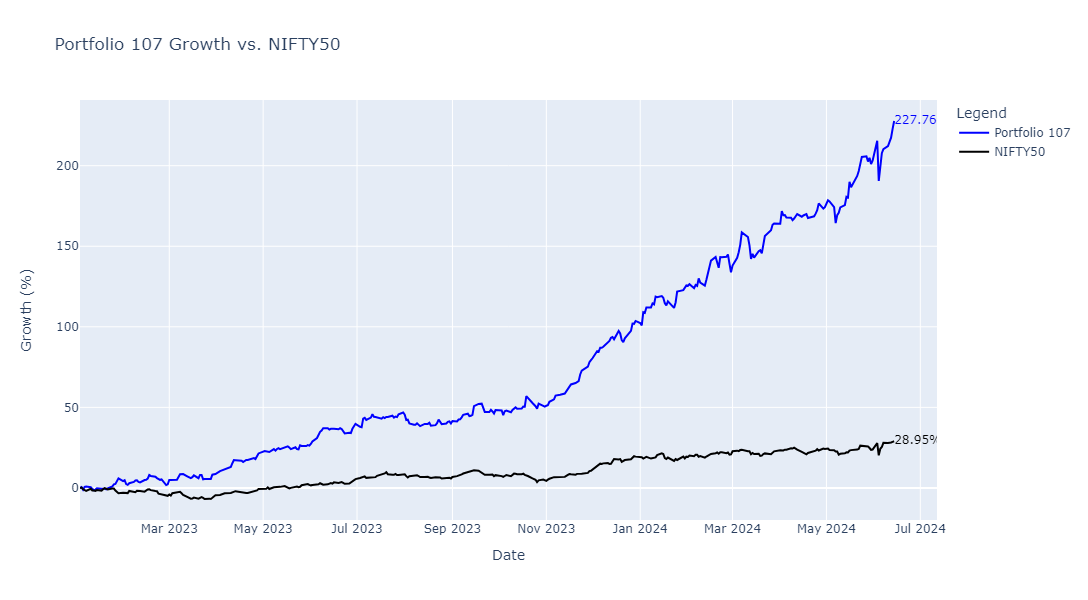

In [28]:

# Define start and end dates
start_date = "2023-01-01"
end_date = "2024-06-15"

# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Function to plot portfolio growth
def plot_portfolio_growth(portfolio_name):
    # Fetch historical stock data for portfolio stocks
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    assets = portfolio_row['Stocks'].iloc[0].split(", ")
    
    # Fetch historical data for each stock in the portfolio
    stock_data = {}
    for asset in assets:
        stock_data[asset] = fetch_historical_data(asset, start_date, end_date)
    
    # Combine historical data for all stocks in the portfolio
    portfolio_data = pd.DataFrame(stock_data)
    
    # Calculate portfolio growth
    portfolio_growth = (portfolio_data.mul(weights, axis=1).sum(axis=1) / portfolio_data.mul(weights, axis=1).sum(axis=1).iloc[0] - 1) * 100
    
    # Calculate cumulative growth for Nifty50
    nifty_growth = (nifty_data / nifty_data.iloc[0] - 1) * 100

    # Plotting with Plotly
    fig = make_subplots()

    
    fig.add_trace(go.Scatter(x=portfolio_growth.index, y=portfolio_growth, mode='lines', name=f'{portfolio_name}', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=nifty_growth.index, y=nifty_growth, mode='lines', name='NIFTY50', line=dict(color='black')))
    
    # Annotate the final value of each line
    final_nifty_return = nifty_growth.iloc[-1]
    final_portfolio_return = portfolio_growth.iloc[-1]
    fig.add_trace(go.Scatter(x=[nifty_growth.index[-1]], y=[final_nifty_return], mode='text', text=[f'{final_nifty_return:.2f}%'], textposition='middle right', showlegend=False, textfont=dict(color='black')))
    fig.add_trace(go.Scatter(x=[portfolio_growth.index[-1]], y=[final_portfolio_return], mode='text', text=[f'{final_portfolio_return:.2f}%'], textposition='middle right', showlegend=False, textfont=dict(color='blue')))

    fig.update_layout(
        title=f'{portfolio_name} Growth vs. NIFTY50',
        xaxis_title='Date',
        yaxis_title='Growth (%)',
        legend_title='Legend',
        hovermode='x unified',
        height=600  # Increase the height of the graph
    )

    fig.show()


# Plot the portfolio growth
plot_portfolio_growth('Portfolio 107')


Enter the name of the portfolio:  Portfolio 107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


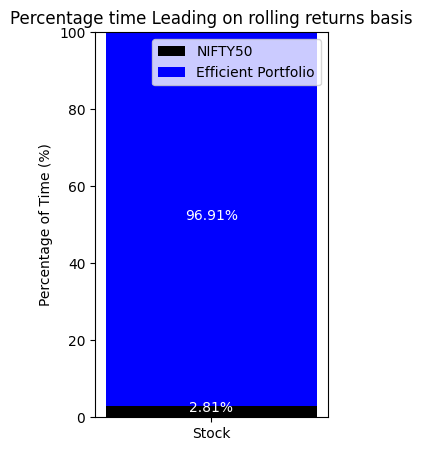

In [30]:
#Percentage time leading on a rolling returns basis

# Define start and end dates
start_date = "2023-01-01"
end_date = "2024-06-15"

# Function to fetch historical stock data
def fetch_historical_data(stock_tickers, start_date, end_date):
    return pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in stock_tickers})

# Function to calculate cumulative returns
def calculate_cumulative_returns(data, weights):
    cumulative_returns = (data.mul(weights, axis=1).sum(axis=1) / data.mul(weights, axis=1).sum(axis=1).iloc[0] - 1) * 100
    return cumulative_returns

# Function to plot percentage time leading
def plot_percentage_time_leading(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Fetch historical stock data for portfolio stocks
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    portfolio_data = fetch_historical_data(stocks, start_date, end_date)
    
    # Calculate cumulative returns for the portfolio
    portfolio_cumulative_returns = calculate_cumulative_returns(portfolio_data, weights)
    
    # Calculate daily returns for NIFTY50
    nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
    nifty_daily_returns = nifty_data.pct_change()
    
    # Calculate cumulative returns for NIFTY50
    nifty_cumulative_returns = (1 + nifty_daily_returns).cumprod() - 1
    
    # Compare cumulative returns and count occurrences
    nifty_outperforms = (nifty_cumulative_returns > portfolio_cumulative_returns).sum()
    portfolio_outperforms = (nifty_cumulative_returns < portfolio_cumulative_returns).sum()
    total_days = len(nifty_cumulative_returns)
    
    # Calculate the percentage of time each outperforms the other
    nifty_outperforms_percentage = nifty_outperforms / total_days * 100
    portfolio_outperforms_percentage = portfolio_outperforms / total_days * 100
    
    # Plotting
    plt.figure(figsize=(3, 5))
    
    # Plot a single stacked bar chart with reduced width
    plt.bar(['Stock'], nifty_outperforms_percentage, width=0.2, color='black', label='NIFTY50')
    plt.bar(['Stock'], portfolio_outperforms_percentage, bottom=nifty_outperforms_percentage, width=0.2, color='blue', label='Efficient Portfolio')
    
    plt.title('Percentage time Leading on rolling returns basis')
    plt.ylabel('Percentage of Time (%)')
    plt.legend()
    
    plt.text('Stock', nifty_outperforms_percentage / 2, f'{nifty_outperforms_percentage:.2f}%', color='white', ha='center')
    plt.text('Stock', nifty_outperforms_percentage + portfolio_outperforms_percentage / 2, f'{portfolio_outperforms_percentage:.2f}%', color='white', ha='center')
    
    plt.ylim(0, 100)
    
    plt.show()

# Example usage:
portfolio_name = input("Enter the name of the portfolio: ")
plot_percentage_time_leading(portfolio_name)


Enter the name of the portfolio:  Portfolio 107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


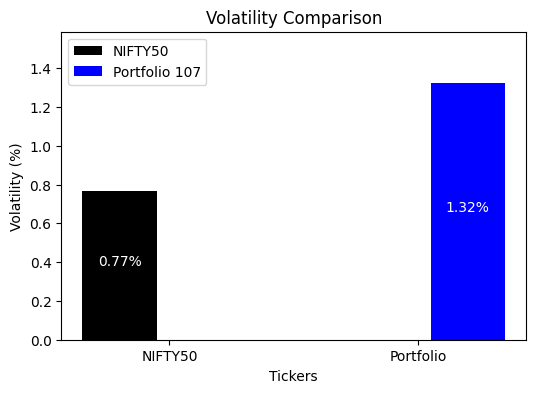

In [31]:
# Define start and end dates
start_date = "2023-01-01"
end_date = "2024-06-15"

# Function to fetch historical stock data
def fetch_historical_data(stock_tickers, start_date, end_date):
    return pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in stock_tickers})

# Function to calculate daily returns
def calculate_daily_returns(data, weights):
    return (data.mul(weights, axis=1).sum(axis=1)).pct_change()

# Function to calculate volatility (standard deviation)
def calculate_volatility(daily_returns):
    return daily_returns.std() * 100  # Converting to percentage

# Function to plot volatility comparison
def plot_volatility_comparison(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Fetch historical stock data for portfolio stocks
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    portfolio_data = fetch_historical_data(stocks, start_date, end_date)
    
    # Calculate daily returns for NIFTY50
    nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
    nifty_daily_returns = nifty_data.pct_change()
    
    # Calculate daily returns for the portfolio
    portfolio_daily_returns = calculate_daily_returns(portfolio_data, weights)
    
    # Calculate volatility for NIFTY50
    nifty_volatility = calculate_volatility(nifty_daily_returns)
    
    # Calculate volatility for the portfolio
    portfolio_volatility = calculate_volatility(portfolio_daily_returns)
    
    # Plotting
    plt.figure(figsize=(6, 4))
    
    # Define the x-axis positions for the bars
    x = np.arange(1.5)
    
    # Plot the volatilities in a bar graph with reduced width
    plt.bar(x - 0.2, [nifty_volatility, 0], width=0.3, color='black', label='NIFTY50')
    plt.bar(x + 0.2, [0, portfolio_volatility], width=0.3, color='blue', label=f'{portfolio_name}')
    
    plt.title('Volatility Comparison')
    plt.xlabel('Tickers')
    plt.ylabel('Volatility (%)')
    plt.xticks(x, ['NIFTY50', 'Portfolio'])
    plt.legend()
    
    # Annotate the bars with the volatility values
    plt.text(x[0] - 0.2, nifty_volatility / 2, f'{nifty_volatility:.2f}%', color='white', ha='center')
    plt.text(x[1] + 0.2, portfolio_volatility / 2, f'{portfolio_volatility:.2f}%', color='white', ha='center')
    
    plt.ylim(0, max(nifty_volatility, portfolio_volatility) * 1.2)  # Set y-axis limit to accommodate the bars
    
    plt.show()

# Example usage:
portfolio_name = input("Enter the name of the portfolio: ")
plot_volatility_comparison(portfolio_name)


Enter the name of the portfolio:  Portfolio 107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Maximum Drawdown:
NIFTY50: -7.06%
Portfolio: -7.89%


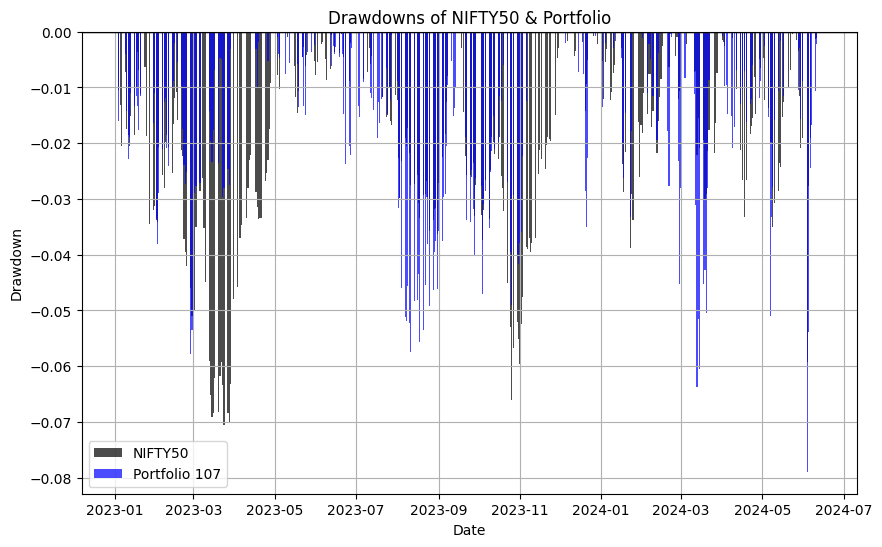

In [32]:
#Drawdown and maximum drawdown of NIFTY50 & Portfolio

# Function to fetch historical stock data
def fetch_historical_data(stock_tickers, start_date, end_date):
    return pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in stock_tickers})

# Function to calculate daily returns
def calculate_daily_returns(data, weights):
    return (data.mul(weights, axis=1).sum(axis=1)).pct_change()

# Function to calculate drawdown
def calculate_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    return drawdown

# Function to plot drawdown
def plot_drawdown(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Fetch historical stock data for portfolio stocks
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    portfolio_data = fetch_historical_data(stocks, start_date, end_date)
    
    # Calculate daily returns for NIFTY50
    nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
    nifty_daily_returns = nifty_data.pct_change()
    
    # Calculate daily returns for the portfolio
    portfolio_daily_returns = calculate_daily_returns(portfolio_data, weights)
    
    # Calculate cumulative returns
    nifty_cumulative_returns = (1 + nifty_daily_returns).cumprod()
    portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()
    
    # Calculate drawdown
    nifty_drawdown = calculate_drawdown(nifty_cumulative_returns)
    portfolio_drawdown = calculate_drawdown(portfolio_cumulative_returns)
    
    # Print maximum drawdown values
    print("Maximum Drawdown:")
    print(f"NIFTY50: {nifty_drawdown.min() * 100:.2f}%")
    print(f"Portfolio: {portfolio_drawdown.min() * 100:.2f}%")
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot the drawdown for NIFTY
    plt.bar(nifty_drawdown.index, nifty_drawdown, color='black', alpha=0.7, label='NIFTY50')
    
    # Plot the drawdown for the portfolio
    plt.bar(portfolio_drawdown.index, portfolio_drawdown, color='blue', alpha=0.7, label= f'{portfolio_name}')
    
    plt.title('Drawdowns of NIFTY50 & Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.axhline(0, color='black', linewidth=1)  # Add a horizontal line at y=0
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
portfolio_name = input("Enter the name of the portfolio: ")
plot_drawdown(portfolio_name)


In [33]:
#Portfolio beta, Treynor measure and Jensan's alpha

# Define the historical data range
start_date = "2023-01-01"
end_date = "2024-06-15"

# Function to fetch historical stock data
def fetch_historical_data(stock_tickers, start_date, end_date):
    stock_data = {}
    for ticker in stock_tickers:
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    return pd.DataFrame(stock_data)

# Function to calculate portfolio returns
def calculate_portfolio_returns(stock_data, weights):
    portfolio_returns = stock_data.pct_change().dropna()
    portfolio_returns = (portfolio_returns * weights).sum(axis=1)
    return portfolio_returns

# Function to calculate portfolio statistics
def calculate_portfolio_statistics(portfolio_returns):
    # Calculate cumulative return for the period
    cumulative_return = (1 + portfolio_returns).prod() - 1
    
    # Annualize cumulative return
    portfolio_annual_return = (1 + cumulative_return) ** (252 / len(portfolio_returns)) - 1
    
    # Calculate standard deviation
    portfolio_std_dev = portfolio_returns.std() * np.sqrt(252)
    
    # Risk-free rate (assuming 7%)
    risk_free_rate = 0.07
    
    # Calculate market returns 
    market_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
    market_returns = market_data.pct_change().dropna()
    
    # Align market returns with portfolio returns
    market_returns = market_returns[:len(portfolio_returns)]
    
    # Calculate beta of the portfolio
    cov_matrix = np.cov(portfolio_returns, market_returns)
    portfolio_beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    
    # Calculate Treynor Measure for the portfolio
    treynor_measure = (portfolio_annual_return - risk_free_rate) / portfolio_beta
    
    # Calculate Jensen's Alpha for the portfolio
    expected_return_market = np.mean(market_returns) * 252
    portfolio_alpha = portfolio_annual_return - (risk_free_rate + portfolio_beta * (expected_return_market - risk_free_rate))
    
    return portfolio_annual_return, portfolio_std_dev, portfolio_beta, treynor_measure, portfolio_alpha

# Function to analyze portfolio
def analyze_portfolio(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Extract stocks and weights for the portfolio
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    
    # Fetch historical stock data for portfolio stocks
    stock_data = fetch_historical_data(stocks, start_date, end_date)
    
    # Calculate portfolio returns
    portfolio_returns = calculate_portfolio_returns(stock_data, weights)
    
    # Calculate portfolio statistics
    portfolio_annual_return, portfolio_std_dev, portfolio_beta, treynor_measure, portfolio_alpha = calculate_portfolio_statistics(portfolio_returns)
    
    # Print portfolio statistics
    print("Portfolio Name:", portfolio_name)
    print("Portfolio Annual Return:", portfolio_annual_return)
    print("Portfolio Standard Deviation:", portfolio_std_dev)
    print("Portfolio Beta:", portfolio_beta)
    print("Treynor Measure:", treynor_measure)
    print("Jensen's Alpha:", portfolio_alpha)

# Example usage:
portfolio_name = input("Enter the name of the portfolio: ")
analyze_portfolio(portfolio_name)


Enter the name of the portfolio:  Portfolio 107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio Name: Portfolio 107
Portfolio Annual Return: 1.4216302906331348
Portfolio Standard Deviation: 0.22132313682768015
Portfolio Beta: 1.0476649323698741
Treynor Measure: 1.2901360433776043
Jensen's Alpha: 1.2280695309789353


In [38]:
#Sharpe ratio

# Define the historical data range
start_date = "2023-01-01"
end_date = "2024-06-15"

# Function to fetch historical stock data
def fetch_historical_data(stock, start, end):
    return yf.download(stock, start=start, end=end)['Adj Close']

# Function to calculate portfolio returns and Sharpe Ratio
def compute_sharpe_ratio(data, weights, risk_free_rate=0.07):
    # Combine stock data into a single DataFrame
    all_stock_data = pd.DataFrame(data)
    
    # Calculate portfolio returns
    stock_returns = all_stock_data.pct_change().dropna()
    
    # Calculate portfolio returns by multiplying the stock weightage to the average stock returns and summing them up
    portfolio_annual_return = (stock_returns.mean() * 252 @ weights)
    
    # Calculate portfolio standard deviation
    portfolio_volatility = np.sqrt(weights.T @ (stock_returns.cov() * 252) @ weights)
    
    # Calculate Sharpe Ratio for the portfolio
    sharpe_ratio = (portfolio_annual_return - risk_free_rate) / portfolio_volatility
    
    return sharpe_ratio[0]  # Return the single Sharpe Ratio value

# Function to analyze portfolio
def analyze_portfolio(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Extract stocks and weights for the portfolio
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    
    # Fetch historical stock data for portfolio stocks
    stock_data = {ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stocks}
    
    # Calculate Sharpe Ratio of the portfolio
    sharpe_ratio_portfolio = compute_sharpe_ratio(stock_data, np.array(weights)[:, np.newaxis])

    print("Portfolio Name:", portfolio_name)
    print("Sharpe Ratio:", sharpe_ratio_portfolio)

# Enter the portfolio number:
portfolio_name = input("Enter the name of the portfolio: ")
analyze_portfolio(portfolio_name)


Enter the name of the portfolio:  Portfolio 107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio Name: Portfolio 107
Sharpe Ratio: 0    3.79835
Name: 0, dtype: float64


In [35]:
#Information ratio & Tracking error

# Define the historical data range
start_date = "2023-01-01"
end_date = "2024-06-15"

# Function to fetch historical stock data
def fetch_historical_data(stock, start_date, end_date):
    return yf.download(stock, start=start_date, end=end_date)['Adj Close']

# Function to calculate annualized returns
def calculate_annualized_returns(data):
    # Calculate daily returns
    daily_returns = data.pct_change().dropna()
    
    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).prod() - 1
    
    # Annualize returns
    annualized_returns = (1 + cumulative_returns) ** (252 / len(data)) - 1  # Assuming 252 trading days in a year
    
    return annualized_returns

# Function to calculate tracking error
def calculate_tracking_error(portfolio_data, benchmark_data):
    # Ensure the lengths of portfolio and benchmark returns match
    if len(portfolio_data) != len(benchmark_data):
        raise ValueError("Portfolio data and benchmark data must have the same length")
    
    # Calculate portfolio returns and benchmark returns
    portfolio_returns = calculate_annualized_returns(portfolio_data)
    benchmark_returns = calculate_annualized_returns(benchmark_data)
    
    # Calculate the difference between portfolio returns and benchmark returns
    tracking_error = portfolio_returns - benchmark_returns
    
    # Calculate the squared tracking error
    squared_tracking_error = tracking_error ** 2
    
    # Calculate the sum of squared tracking errors
    sum_squared_tracking_error = np.sum(squared_tracking_error)
    
    # Calculate the mean squared tracking error
    mean_squared_tracking_error = sum_squared_tracking_error / (len(portfolio_returns) - 1)
    
    # Calculate the tracking error (standard deviation of the difference in returns)
    tracking_error = np.sqrt(mean_squared_tracking_error)
    
    return tracking_error

# Function to calculate information ratio for the entire portfolio
def calculate_portfolio_information_ratio(portfolio_data, benchmark_data, tracking_error):
    # Calculate annualized returns for portfolio and benchmark
    portfolio_returns = calculate_annualized_returns(portfolio_data)
    benchmark_returns = calculate_annualized_returns(benchmark_data)
    
    # Calculate weighted average portfolio return
    portfolio_weighted_return = (portfolio_returns.values * weights[:, np.newaxis]).sum()
    
    # Calculate information ratio for the entire portfolio
    information_ratio = (portfolio_weighted_return - benchmark_returns) / tracking_error
    
    return information_ratio

# Function to analyze portfolio
def analyze_portfolio(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Extract stocks and weights for the portfolio
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    
    # Fetch historical stock data for portfolio stocks
    stock_data = {ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stocks}
    
    # Fetch historical stock data for benchmark
    benchmark_data = fetch_historical_data('^NSEI', start_date, end_date)
    
    # Calculate tracking error
    tracking_error = calculate_tracking_error(pd.DataFrame(stock_data), benchmark_data)
    
    # Calculate information ratio for the entire portfolio
    portfolio_information_ratio = calculate_portfolio_information_ratio(pd.DataFrame(stock_data), benchmark_data, tracking_error)
    
    print("Portfolio Name:", portfolio_name)
    print("Information Ratio:", portfolio_information_ratio)
    print("Tracking Error:", tracking_error)

# Enter the portfolio details
portfolio_name = input("Enter the name of the portfolio: ")
analyze_portfolio(portfolio_name)


Enter the name of the portfolio:  Portfolio 107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio Name: Portfolio 107
Information Ratio: 3.748942116973788
Tracking Error: 1.1922842352226748


In [36]:
#Value at Risk (VaR) of the portfolio

def get_historical_returns(tickers, start_date, end_date):
    """
    Fetch historical price data for the specified tickers and calculate daily returns.
    
    Args:
    - tickers: List of ticker symbols for the assets in the portfolio
    - start_date: Start date for historical data (YYYY-MM-DD)
    - end_date: End date for historical data (YYYY-MM-DD)
    
    Returns:
    - returns: DataFrame containing daily returns for each asset
    """
    price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    daily_returns = price_data.pct_change().dropna()
    return daily_returns

def calculate_portfolio_var(daily_returns, weights, confidence_level):
    """
    Calculate Value at Risk (VaR) of a portfolio using historical simulation.
    
    Args:
    - daily_returns: DataFrame containing daily returns for each asset
    - weights: Array-like object containing the weights of individual assets in the portfolio
    - confidence_level: Desired confidence level (e.g., 0.95 for 95% confidence)
    
    Returns:
    - var: Value at Risk of the portfolio
    """
    # Calculate portfolio daily returns
    portfolio_returns = daily_returns.dot(weights)
    
    # Calculate VaR
    var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    return var

if __name__ == "__main__":
    
    
    portfolio_name = input("Enter the name of the portfolio: ")
    start_date = input("Enter start date for historical data (YYYY-MM-DD): ")
    end_date = input("Enter end date for historical data (YYYY-MM-DD): ")
    confidence_level = float(input("Enter confidence level (e.g., 0.95 for 95% confidence): "))

    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
    else:
        # Extract stocks and weights for the portfolio
        tickers = portfolio_row['Stocks'].iloc[0].split(", ")
        weights = np.array([float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")])
        
        # Fetch historical returns
        daily_returns = get_historical_returns(tickers, start_date, end_date)
        
        # Calculate VaR of the portfolio
        portfolio_var = calculate_portfolio_var(daily_returns, weights, confidence_level)
        
        # Output results
        print(f"Value at Risk (VaR) of the portfolio at {confidence_level*100}% confidence level: {portfolio_var*100}%")


Enter the name of the portfolio:  Portfolio 107
Enter start date for historical data (YYYY-MM-DD):  2023-01-01
Enter end date for historical data (YYYY-MM-DD):  2024-06-15
Enter confidence level (e.g., 0.95 for 95% confidence):  0.99


[*********************100%%**********************]  4 of 4 completed
Value at Risk (VaR) of the portfolio at 99.0% confidence level: -2.5179867327758685%


Enter the name of the portfolio:  Portfolio 107
Enter start date for historical data (YYYY-MM-DD):  2023-01-01
Enter end date for historical data (YYYY-MM-DD):  2024-06-15


[*********************100%%**********************]  4 of 4 completed


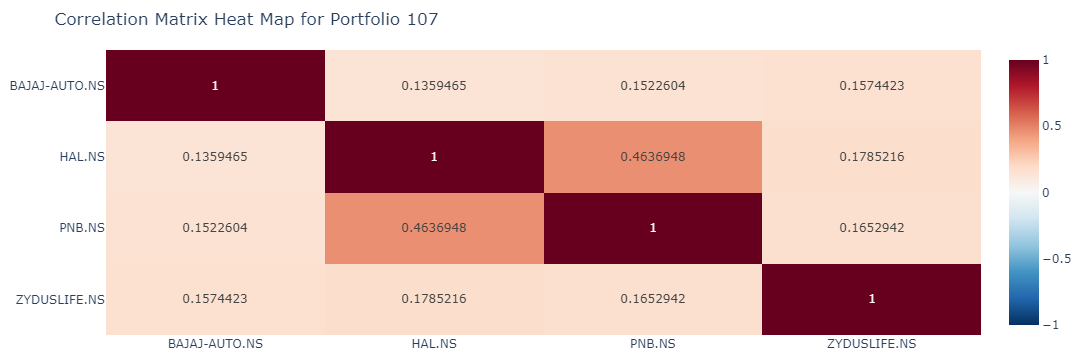

In [37]:
def get_historical_data(tickers, start_date, end_date):
    """
    Fetch historical price data for the specified tickers.
    
    Args:
    - tickers: List of ticker symbols for the assets in the portfolio
    - start_date: Start date for historical data (YYYY-MM-DD)
    - end_date: End date for historical data (YYYY-MM-DD)
    
    Returns:
    - price_data: DataFrame containing historical price data for each asset
    """
    price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return price_data

def calculate_correlation_matrix(price_data):
    """
    Calculate the correlation matrix for the given price data.
    
    Args:
    - price_data: DataFrame containing historical price data for each asset
    
    Returns:
    - correlation_matrix: DataFrame containing the correlation matrix
    """
    correlation_matrix = price_data.pct_change().dropna().corr()
    return correlation_matrix

def plot_correlation_heatmap(correlation_matrix, portfolio_name):
    """
    Plot an interactive heat map for the given correlation matrix using Plotly.
    
    Args:
    - correlation_matrix: DataFrame containing the correlation matrix
    - portfolio_name: Name of the portfolio
    """
    fig = px.imshow(correlation_matrix, 
                    text_auto=True, 
                    aspect="auto",
                    color_continuous_scale='RdBu_r',
                    zmin=-1, zmax=1,
                    title=f'Correlation Matrix Heat Map for {portfolio_name}')
    
    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10))
    fig.show()

if __name__ == "__main__":
    portfolio_name = input("Enter the name of the portfolio: ")
    start_date = input("Enter start date for historical data (YYYY-MM-DD): ")
    end_date = input("Enter end date for historical data (YYYY-MM-DD): ")

    
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
    else:
        # Extract stocks for the portfolio
        tickers = portfolio_row['Stocks'].iloc[0].split(", ")
        
        # Fetch historical price data
        price_data = get_historical_data(tickers, start_date, end_date)
        
        # Calculate correlation matrix
        correlation_matrix = calculate_correlation_matrix(price_data)
        
        # Plot correlation matrix heat map
        plot_correlation_heatmap(correlation_matrix, portfolio_name)
